In [52]:
import cobra
import pandas as pd

In [41]:
import modelmaker_dilution

In [2]:
model = cobra.io.read_sbml_model("model.xml")

'' is not a valid SBML 'SId'.


In [44]:
model = modelmaker_dilution.add_dilution_reactions(model)
model = modelmaker_dilution.add_dilution_constraints(model, 1000)

The given_model passed to add_dilution_reactions appears to already have at least one dilution reaction; returning the model as-is


In [47]:
model.optimize()

,fluxes,reduced_costs
rxn02201_c0,0.0,0.000000
rxn00351_c0,0.0,0.000000
rxn07431_c0,0.0,0.000000
rxn00836_c0,0.0,0.000000
rxn00423_c0,0.0,0.000000
...,...,...
cpd00099_c0_dilution,0.0,0.000000
cpd00149_c0_dilution,0.0,0.000000
cpd15793_c0_dilution,0.0,-80.633933
cpd11416_c0_dilution,0.0,0.000000


In [49]:
fva_res = cobra.flux_analysis.flux_variability_analysis(model, model.reactions)

/Users/helenscott/opt/miniconda3/envs/med4-hot1a3/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/helenscott/opt/miniconda3/envs/med4-hot1a3/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/helenscott/opt/miniconda3/envs/med4-hot1a3/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/helenscott/opt/miniconda3/envs/med4-hot1a3/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=

In [54]:
# Save the results to a csv file
fva_res.to_csv("fva_res.csv")

In [53]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print (fva_res)

                           minimum       maximum
rxn02201_c0           0.000000e+00  0.000000e+00
rxn00351_c0           0.000000e+00  9.960080e+02
rxn07431_c0           0.000000e+00  0.000000e+00
rxn00836_c0          -9.969215e+02  0.000000e+00
rxn00423_c0           0.000000e+00  0.000000e+00
rxn00364_c0          -9.920319e+02  1.000000e+03
rxn05561_c0          -1.000000e+03  9.980020e+02
rxn03408_c0           0.000000e+00  0.000000e+00
rxn02177_c0           0.000000e+00  0.000000e+00
rxn05250_c0           0.000000e+00  0.000000e+00
rxn00646_c0           0.000000e+00  9.980020e+02
rxn01673_c0           0.000000e+00  0.000000e+00
rxn00247_c0           0.000000e+00  1.000000e+03
rxn02342_c0           0.000000e+00  0.000000e+00
rxn00022_c0           0.000000e+00  0.000000e+00
rxn02000_c0           0.000000e+00  5.990014e+00
rxn03239_c0           0.000000e+00  0.000000e+00
rxn05457_c0           0.000000e+00  0.000000e+00
rxn00107_c0           0.000000e+00  0.000000e+00
rxn12008_c0         

In [55]:
import networkx as nx

In [68]:
# Make a function that goes from a list of reactions to a networkx graph
def rxns_to_graph(rxns):
    g = nx.Graph()
    for rxn_id in rxns:
        # Get the reaction from the model
        reaction = model.reactions.get_by_id(rxn_id)
        # Add a node for the reaction
        g.add_node(reaction.id, bipartite=0)
        # Add a node for each metabolite
        for metabolite in reaction.metabolites.keys():
            g.add_node(metabolite.id, bipartite=1)
            # Add an edge between the reaction and metabolite
            g.add_edge(reaction.id, metabolite.id)
    return g


In [62]:
# Get just the reactions in fva_res that have a delta of 2000
rxns = fva_res[(fva_res["maximum"] - fva_res["minimum"]) >= 2000].index.to_list()

In [69]:
delta2k_rxn_g = rxns_to_graph(rxns)

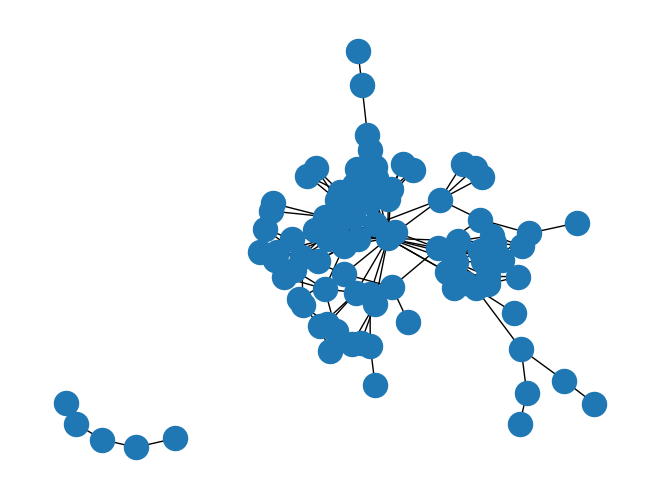

In [70]:
nx.draw(delta2k_rxn_g)